In [80]:
using Plots
using LinearAlgebra
using SpecialFunctions
using Optim

In [2]:
# Helpful structs
struct Gaussian
    exponent::Float64
    center::AbstractArray{<:Float64, 1}
end


struct Atom
    charge::Int64
    position::AbstractArray{<:Float64, 1}
    #gaussians::AbstractArray{Gaussian,1}
end


struct Molecule
    atoms::AbstractArray{Atom,1}
    gaussians::AbstractArray{Gaussian,1}
    exponents::Array{Float64,1}
    electrons::Int64
end

# This is just so that we can keep track of our variables
mutable struct HFObject
    molecule::Molecule
    S::AbstractArray{<:Float64,2}
    P::AbstractArray{<:Float64,2}
    T::AbstractArray{<:Float64,2}
    V::AbstractArray{<:Float64,2}
    M0::AbstractArray{<:Float64,4}
    M1::AbstractArray{<:Float64,4}
    H::AbstractArray{<:Float64,2}
    G::AbstractArray{<:Float64,2}
    F::AbstractArray{<:Float64,2}
    C::AbstractArray{<:Float64,2}
end
#############

In [3]:
# Integral functions
function overlap_integral(A::T, B::T) where T<:Gaussian
    α = A.exponent
    β = B.exponent
    R_A = A.center
    R_B = B.center
    
    return (4*α*β / (α + β) ^ 2) ^ (3/4) * exp(-α*β / (α + β) * norm(R_A - R_B)^2)
end

function overlap_integral(arr::Tuple{T, T}) where T <: Gaussian
    return overlap_integral(arr[1], arr[2])
end


function kinetic_integral(A::T, B::T) where T<:Gaussian
    α = A.exponent
    β = B.exponent
    R_A = A.center
    R_B = B.center
    
    a = α * β / (α + β)
    
    return overlap_integral(A, B) * a * (3 - 2 * a * norm(R_A - R_B)^2)
end

function kinetic_integral(arr::Tuple{T, T}) where T <: Gaussian
    return kinetic_integral(arr[1], arr[2])
end


function core_potential_integral(A::T, B::T, C::Atom) where T<:Gaussian
    α = A.exponent
    β = B.exponent
    R_A = A.center
    R_B = B.center
    R_C = C.position
    Z = C.charge
        
    b = sqrt(α + β)
    
    R_P = (α * R_A + β * R_B) / (α + β)
    
    if R_P == R_C
        return -overlap_integral(A, B) * Z * 2 * b / sqrt(π)
    else
        return -overlap_integral(A, B) * Z / norm(R_P - R_C) * erf(b * norm(R_P - R_C))
    end
end

function core_potential_integral(A::T, B::T, atoms::AbstractArray{Atom,1}) where T<:Gaussian
    return sum(core_potential_integral(A, B, a) for a in atoms)
end

function core_potential_integral(arr::Tuple{T, T}, atoms::AbstractArray{Atom,1}) where T<:Gaussian
    return core_potential_integral(arr[1], arr[2], atoms)
end


# TODO: re-use overlap integrals
# Calculating a lot of overlap integrals everywhere...
function coulomb_integral(A::T, B::T, C::T, D::T) where T<:Gaussian
    α = A.exponent
    β = B.exponent
    γ = C.exponent
    δ = D.exponent
    
    R_A = A.center
    R_B = B.center
    R_C = C.center
    R_D = D.center
    
    R_P = (α * R_A + β * R_B) / (α + β)
    R_Q = (γ * R_C + δ * R_D) / (γ + δ)
    
    c = sqrt((α + β) * (γ + δ) / (α + β + γ + δ))
    
    if R_P == R_Q 
        return overlap_integral(A, B) * overlap_integral(C, D) * 2 * c / sqrt(π)
    else
        return overlap_integral(A, B) * overlap_integral(C, D) / norm(R_P - R_Q) * erf(c * norm(R_P - R_Q))
    end
end

function coulomb_integral(arr::NTuple{4, Gaussian})
    return coulomb_integral(arr[1], arr[2], arr[3], arr[4])
end


function exchange_integral(A::T, B::T, C::T, D::T) where T<:Gaussian
    return coulomb_integral(A, C, B, D) # Just change place
end

function exchange_integral(arr::NTuple{4, Gaussian})
    return exchange_integral(arr[1], arr[2], arr[3], arr[4])
end

#################

exchange_integral (generic function with 2 methods)

In [4]:
# Reading molecular info from file
function read_mol_settings(filename)
    positions = []
    exponents = []
    electrons = 0
    open(filename, "r") do mol_file
        while !eof(mol_file)
            line = readline(mol_file)
            if line == "COORDINATES:"
                while line != "==="
                    line = readline(mol_file)
                    if line == "==="
                        break
                    end
                    push!(positions, map(x->parse(Float64, x), split(line))) 
                end
            end
            if line == "EXPONENTS:"
                while line != "==="
                    line = readline(mol_file)
                    if line == "==="
                        break
                    end
                    push!(exponents, tryparse(Float64, line)) 
                end
            end
            if line == "ELECTRONS:"
                line = readline(mol_file)
                electrons += tryparse(Int64, line)
            end
        end
    end

    atoms = Array{Atom}(undef, length(positions))
    gaussians = Array{Gaussian}(undef, length(positions) * length(exponents))

    n = 1
    for e in exponents
        for p in positions
            if n <= length(positions)
                atoms[n] = Atom(1, p)
            end
            gaussians[n] = Gaussian(e, p)
            n += 1
        end
    end
    
    molecule = Molecule(atoms, gaussians, exponents, electrons)
    return molecule
end

read_mol_settings (generic function with 1 method)

In [5]:
function one_body_operators(molecule::Molecule)
    atoms = molecule.atoms
    gaussians = molecule.gaussians
    
    one_body = Iterators.product(gaussians, gaussians)
    S = map(x->overlap_integral(x), one_body)
    T = map(x->kinetic_integral(x), one_body)
    V = map(x->core_potential_integral(x, atoms), one_body) 
    
    return S, T, V
end
function one_body_operators(hf_obj::HFObject)
    S, T, V = one_body_operators(hf_obj.molecule)
    return S, T, V
end

function two_body_operators(molecule::Molecule, P)
    atoms = molecule.atoms
    gaussians = molecule.gaussians
    K = length(gaussians)
    
    two_body = Iterators.product(gaussians, gaussians, gaussians, gaussians)
    M0 = map(x->coulomb_integral(x), two_body)
    M1 = map(x->exchange_integral(x), two_body)
    M = M0 + M1
    
    M_reshaped = reshape(M, K^2, K^2) # have to reshape for multiplication
    G = reshape(M_reshaped * P[:], K, K)
    
    return M0, M1, G
end

function core_hamiltonian(molecule::Molecule)
    S, T, V = one_body_operators(molecule)
    H = T + V
    return H
end


function electron_electron_hamiltonian(molecule::Molecule, P)
    K = length(molecule.gaussians)
    N = molecule.electrons

    M0, M1, G = two_body_operators(molecule, P)
    
    return G
end

function fock_matrix(molecule::Molecule)
    H = core_hamiltonian(molecule)
    G = electron_electron_hamiltonian(molecule)
    F = G + H
    return F
end


function p_matrix(C, N)
    P = 2 * C[:, 1:N ÷ 2] * C[:, 1:N ÷ 2]'
    return P
end


# Energy calculations
function electron_energy(hf_obj::HFObject)
    E = 1/2 * sum(hf_obj.P .* (hf_obj.H + hf_obj.F))
    
    return E
end


function nuclear_repulsion_energy(A::Atom, B::Atom)
    E = A.charge * B.charge / norm(A.position - B.position)
    return E
end

function nuclear_repulsion_energy(atoms::AbstractArray{Atom})
    E = 0
    for (i, a1) in enumerate(atoms[1:end-1])
        for a2 in atoms[i+1:end]
            E += nuclear_repulsion_energy(a1, a2)
        end
    end
    
    return E
end


function total_energy(hf_obj::HFObject)
    E_tot = electron_energy(hf_obj) + nuclear_repulsion_energy(hf_obj.molecule.atoms)
    return E_tot
end



# Hartree-Fock functions
function construct_hf_object(molecule::Molecule, C)
    atoms = molecule.atoms
    gaussians = molecule.gaussians
    N = molecule.electrons
    
    S, T, V = one_body_operators(molecule)
    H = T + V

    P = 2 * C[:, 1:N ÷ 2] * C[:, 1:N ÷ 2]'
    M0, M1, G = two_body_operators(molecule, P)
    F = H + G
    
    
    return HFObject(molecule, S, P, T, V, M0, M1, H, G, F, C)
end


function hf_step(hf_obj::HFObject)
    
    molecule = hf_obj.molecule
    gaussians = molecule.gaussians
    atoms = molecule.atoms
    N = molecule.electrons
    K = length(gaussians)

    one_body = Iterators.product(gaussians, gaussians)
    S = map(x->overlap_integral(x), one_body)
    T = map(x->kinetic_integral(x), one_body)
    V = map(x->core_potential_integral(x, atoms), one_body)

    H = T + V

    two_body = Iterators.product(gaussians, gaussians, gaussians, gaussians)
    M0 = map(x->coulomb_integral(x), two_body)
    M1 = map(x->exchange_integral(x), two_body)
    M = M0 - 1/2 * M1

    M_reshaped = reshape(M, K^2, K^2) # have to reshape for multiplication
    G = reshape(M_reshaped * hf_obj.P[:], K, K)
    F = H + G

    X = S^(-1/2)
    F_dash = Symmetric(X * F * X)

    eigen_obj = eigen(F_dash)

    E, B = eigen_obj # These are sorted by default
    C = X * B
    
    P = 2 * C[:, 1:N ÷ 2] * C[:, 1:N ÷ 2]'
    return HFObject(molecule, S, P, T, V, M0, M1, H, G, F, C)
end

function hf_step(molecule::Molecule, C)
    atoms = molecule.atoms
    gaussians = molecule.gaussians
    
    H = core_hamiltonian(molecule)
    G = electron_electron_hamiltonian(molecule, C)
    F = H + G

    X = S^(-1/2)
    F_dash = X * F * X

    eigen_obj = eigen(F_dash)
    E, B = eigen_obj # These are sorted by default
    C = X * B
    
    return C
end


# Run HF until convergence
function hartree_fock(molecule::Molecule; initial_guess=undef, tol::Float64=1e-6)
    N = molecule.electrons
    K = length(molecule.gaussians)
    
    if initial_guess == undef
        C = ones(K,K)
    else
        C = initial_guess
    end
    
    diff = Inf
    hf_old = construct_hf_object(molecule, C)
    iterations = 0
    
    while diff > tol
        iterations += 1
        hf_new = hf_step(hf_old)
        diff = norm(hf_new.P - hf_old.P)
        hf_old = hf_new
    end
    #println("Converged after $iterations iterations")
    return hf_old
end

hartree_fock (generic function with 1 method)

In [6]:
# Geometry optimization
function optimize_geometry(initial_molecule::Molecule)
    
    exponents = initial_molecule.exponents
    electrons = initial_molecule.electrons
    initial_positons = vcat([a.position for a in molecule.atoms]...)

    function energy_of_geometry(coordinates::Array{<:Number,1})
        positions = reshape(coordinates, 3, length(coordinates)÷3)
        atoms = Array{Atom}(undef, size(positions)[2])
        gaussians = Array{Gaussian}(undef,size(positions)[2]*length(exponents))
        
        create_atoms = true
        n = 1
        for e in exponents
            for p in eachcol(positions)
                if create_atoms
                    atoms[n] = Atom(1, p)
                end
                gaussians[n] = Gaussian(e, p)
                n += 1
            end
            create_atoms = false
        end
        
        new_molecule = Molecule(atoms, gaussians, exponents, electrons)
        hf_obj = hartree_fock(new_molecule, tol=1e-12)
        E_tot = total_energy(hf_obj)
        #println(E_tot)
        return E_tot
    end
    
    #energy_of_geometry(initial_positons)
    optimize(energy_of_geometry, initial_positons)
end

optimize_geometry (generic function with 1 method)

In [55]:
N = 100
Atob = 1/0.529177210903
X = LinRange(0.3*Atob, 2*Atob, N)
energies = Array{Float64,1}(undef,N)

for (i, x) in enumerate(X)
    positions = [[0,0,0],[x, 0, 0]]#,[cos(pi/3)*x, sin(pi/3)*x, 0]]
    exponents = [0.3425250914e1, 0.6239137298, 0.1688554040]
    atoms = Array{Atom}(undef, length(positions))
    gaussians = Array{Gaussian}(undef,length(positions)*length(exponents))
    
    create_atoms = true
    n = 1
    for e in exponents
        for p in positions
            if create_atoms
                atoms[n] = Atom(1, p)
            end
            gaussians[n] = Gaussian(e, p)
            n += 1
        end
        create_atoms = false
    end
    
    molecule = Molecule(atoms, gaussians, exponents, 2)

    hf_obj = hartree_fock(molecule, tol=1e-12)

    energies[i] = total_energy(hf_obj)
    print(" ",i)
end

 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100

In [51]:
i = argmin(energies)
X[i]/Atob

0.8732323232323232

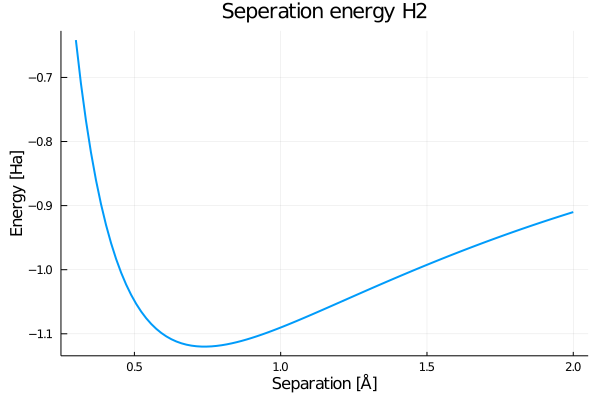

In [58]:
plot(
    X/Atob,
    energies,
    1,
    title = "Seperation energy H2",
    xlabel = "Separation [Å]",
    ylabel = "Energy [Ha]",
    lw = 2,
    label = nothing
)

In [59]:
savefig("H2_Bond")

In [67]:
molecule = read_mol_settings("H3+.txt")
result = optimize_geometry(molecule)

 * Status: success

 * Candidate solution
    Final objective value:     -1.272154e+00

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   117  (vs limit Inf)
    Iterations:    171
    f(x) calls:    330


In [79]:
minimum_energy = result.minimum
display(minimum_energy)

optimal_coords = result.minimizer
optimal_coords = reshape(optimal_coords, 3, length(optimal_coords)÷3)

sep = optimal_coords - circshift(optimal_coords,(0,1))
for c = eachcol(sep)
    display(norm(c) * 5.29e-1)
end

display(sum([norm(c) for c in eachcol(sep)])* 5.29e-1/3)

-1.2721540152011062

0.8727804819190454

0.8727295931877656

0.8726916598673633

0.8727339116580581

In [10]:
println("Core potential integrals")
for g1 in gaussians
    for g2 in gaussians
        V = sum(core_potential_integral(g1, g2, a) for a in atoms)
        print(V, " ")
    end
    println()
end

println("\nKinetic integrals")
for g1 in gaussians
    for g2 in gaussians
        T = kinetic_integral(g1, g2)
        print(T, " ")
    end
end

println("\nElectron-electron integrals")
for (i, g1) in enumerate(gaussians)
    for (j, g2) in enumerate(gaussians)
        for (k, g3) in enumerate(gaussians)
            for (l, g4) in enumerate(gaussians)
                M0 = electron_electron_potential(g1, g2, g3, g4)
                M1 = exchange_integral(g1, g2, g3, g4)
                println("($(i)$(j)|$(k)$(l)) ", M0 - 1/2 * M1, " ")
            end
        end
    end
end

Core potential integrals


LoadError: UndefVarError: gaussians not defined